# Etapa 2. Ajuste, automatización y uso de modelos de analítica de textos.

### Sección 1. (20%) Aumentación de datos y reentrenamiento del modelo.

In [9]:
DATA_STAGE2 = "datosetapa2.xlsx"  
TEXT_COL = "textos"
LABEL_COL = "labels"
MODEL_PATH = "models/best_model.joblib"       

import pandas as pd
import numpy as np
import joblib
from pathlib import Path

if DATA_STAGE2.endswith(".xlsx"):
    df2 = pd.read_excel(DATA_STAGE2)
else:
    df2 = pd.read_csv(DATA_STAGE2)

assert TEXT_COL in df2.columns and LABEL_COL in df2.columns, df2.columns.tolist()
df2 = df2[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)


model = joblib.load(MODEL_PATH)
model


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=20000, min_df=2,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=2000,
                               n_jobs=-1, random_state=42))])

### Evaluación del modelo actual sobre Etapa 2 (baseline)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

X2 = df2[TEXT_COL].astype(str)

# Opción A: trabajar TODO como string
y2 = df2[LABEL_COL].astype(str)                 # "1","3","4"
y2_pred = model.predict(X2)
y2_pred = pd.Series(y2_pred).astype(str).values # "1","3","4"

labels_sorted = sorted(np.unique(np.concatenate([y2.values, y2_pred])))
rep2 = classification_report(y2, y2_pred, labels=labels_sorted,
                             output_dict=True, zero_division=0)
cm2 = confusion_matrix(y2, y2_pred, labels=labels_sorted)


In [12]:
print("y_true dtype:", pd.Series(y2).dtype)
print("y_pred dtype:", pd.Series(y2_pred).dtype)
print("unique y_true:", sorted(pd.Series(y2).unique())[:5])
print("unique y_pred:", sorted(pd.Series(y2_pred).unique())[:5])

y_true dtype: object
y_pred dtype: object
unique y_true: ['1', '3', '4']
unique y_pred: ['1', '3', '4']


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import numpy as np
import pandas as pd
from pathlib import Path
import json

# 1) classification_report (dict) + macro metrics
labels_sorted = sorted(np.unique(np.concatenate([pd.Series(y2).values, pd.Series(y2_pred).values])))
rep = classification_report(y2, y2_pred, labels=labels_sorted, output_dict=True, zero_division=0)

macro_metrics = {
    "precision": rep["macro avg"]["precision"],
    "recall":    rep["macro avg"]["recall"],
    "f1":        rep["macro avg"]["f1-score"],
    "accuracy":  rep["accuracy"]
}
macro_metrics


{'precision': 0.8383178474641889,
 'recall': 0.8060538944259874,
 'f1': 0.815022815022815,
 'accuracy': 0.8282828282828283}

In [14]:
# 2) Tabla por clase (precision/recall/f1/support)
per_class_rows = []
for lbl in labels_sorted:
    per_class_rows.append({
        "label": str(lbl),
        "precision": rep[str(lbl)]["precision"],
        "recall":    rep[str(lbl)]["recall"],
        "f1":        rep[str(lbl)]["f1-score"],
        "support":   int(rep[str(lbl)]["support"]),
    })
df_per_class = pd.DataFrame(per_class_rows)
df_per_class


,label,precision,recall,f1,support
0,1,0.875000,0.666667,0.756757,21
1,3,0.761905,0.914286,0.831169,35
2,4,0.878049,0.837209,0.857143,43


In [ ]:
ODS_MAP = {"1": "Fin de la pobreza", "3": "Salud y bienestar", "4": "Educación de calidad"}
df_per_class_named = df_per_class.assign(ODS=df_per_class["label"].map(ODS_MAP))[["label","ODS","precision","recall","f1","support"]]
df_per_class_named


,label,ODS,precision,recall,f1,support
0,1,Fin de la pobreza,0.875000,0.666667,0.756757,21
1,3,Salud y bienestar,0.761905,0.914286,0.831169,35
2,4,Educación de calidad,0.878049,0.837209,0.857143,43


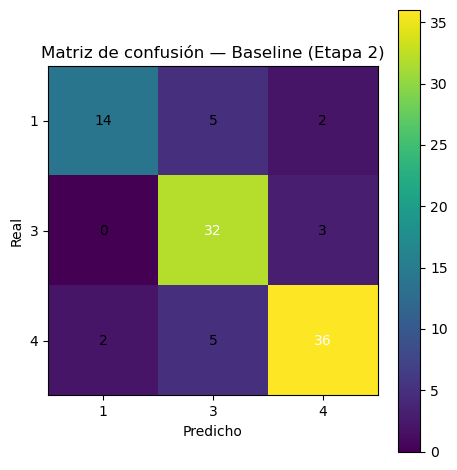

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y2, y2_pred, labels=labels_sorted)

fig = plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión — Baseline (Etapa 2)")
plt.colorbar()
tick_marks = np.arange(len(labels_sorted))
plt.xticks(tick_marks, labels_sorted)
plt.yticks(tick_marks, labels_sorted)
plt.xlabel("Predicho")
plt.ylabel("Real")

# Anotar valores
th = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")
plt.tight_layout()
plt.show()


### Aumentación por prompting para la clase minoritaria

In [17]:
df2[LABEL_COL].value_counts().sort_values()


labels
1    21
3    35
4    43
Name: count, dtype: int64